## DATA 245 Fall 2021 Project
Group 2: Canaan Law, Chitra Priyaa Sathya Moorthy, Haotong Qiu, Jie Dong, Lianglei Zhang, Rick Gosalvez

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import skimage
from skimage import transform
import cv2

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from tqdm import tqdm

### Import Data

In [2]:
# endpoints (Rick)
folder_benign_train = 'data/train/benign'
folder_malignant_train = 'data/train/malignant'

folder_benign_test = 'data/test/benign'
folder_malignant_test = 'data/test/malignant'

In [3]:
img_size = 200
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')


### Preprocess Images

In [4]:
img_size = (200, 200)

## Resize function
def _resize_image(image, target):
   return cv2.resize(image, dsize=(target[0], target[1]), interpolation=cv2.INTER_LINEAR)

image = [_resize_image(image=i, target=img_size) for i in X_benign]
X_benign = np.stack(image, axis=0)

image = [_resize_image(image=i, target=img_size) for i in X_malignant]
X_malignant = np.stack(image, axis=0)

image = [_resize_image(image=i, target=img_size) for i in X_benign_test]
X_benign_test = np.stack(image, axis=0)

image = [_resize_image(image=i, target=img_size) for i in X_malignant_test]
X_malignant_test = np.stack(image, axis=0)

In [5]:
X_benign.shape

(1440, 200, 200, 3)

### Split into Train and Test

In [6]:
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

### Explore Data

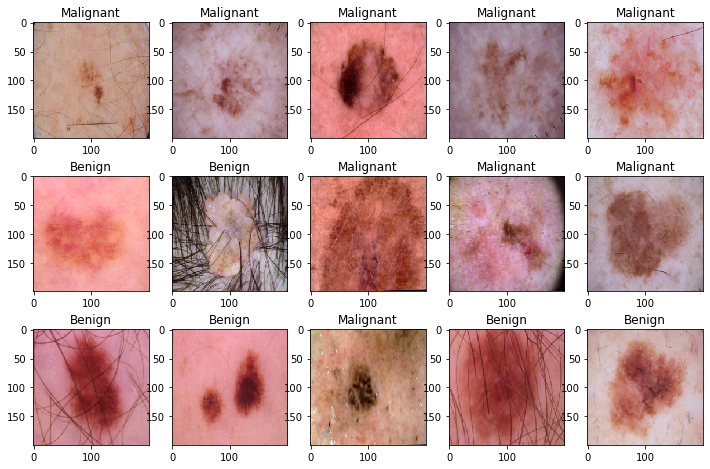

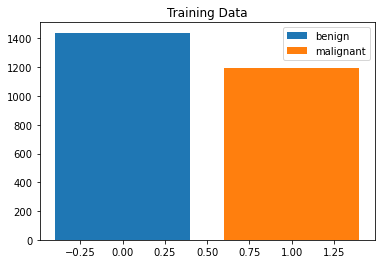

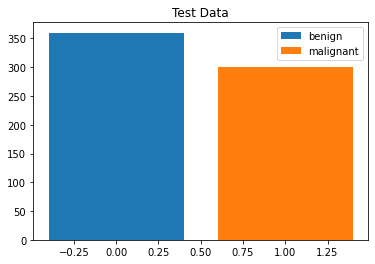

In [7]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()


plt.bar(0, y_train[np.where(y_train == 0)].shape[0], label = 'benign')
plt.bar(1, y_train[np.where(y_train == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()

plt.bar(0, y_test[np.where(y_test == 0)].shape[0], label = 'benign')
plt.bar(1, y_test[np.where(y_test == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Test Data")
plt.show()


X_train = X_train/255.
X_test = X_test/255.

### SVM

In [8]:
# support vector machine classifier
#This is only a simple demostration if we apply any models on the training dataset
from sklearn.svm import SVC
model = SVC()
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
print(f'Accuracy Score: {accuracy_score(y_test, y_pred):.3f}')
print()
print(classification_report(y_test, y_pred))

Accuracy Score: 0.835

              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84       360
         1.0       0.80      0.86      0.83       300

    accuracy                           0.83       660
   macro avg       0.83      0.84      0.83       660
weighted avg       0.84      0.83      0.84       660



### KNN

In [12]:
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3) 
knn_model.fit(X_train.reshape(X_train.shape[0],-1), y_train)
from sklearn.metrics import accuracy_score
y_pred = knn_model.predict(X_test.reshape(X_test.shape[0],-1))
print(f'Accuracy Score: {accuracy_score(y_test, y_pred):.3f}')

Accuracy Score: 0.761


Text(0.5, 0.98, 'kNN hyperparameter (k) tuning')

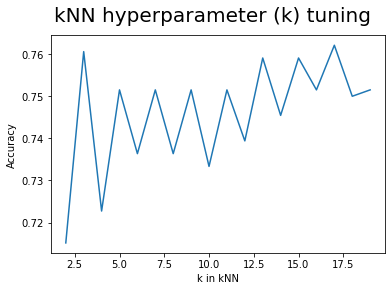

In [11]:
## tune best k 
accus = []
ks = list(range(2,20))
for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train.reshape(X_train.shape[0],-1), y_train)
    y_pred = knn_model.predict(X_test.reshape(X_test.shape[0],-1))
    accus.append(accuracy_score(y_test, y_pred))
fig = plt.figure()
plt.plot(ks, accus)
plt.xlabel('k in kNN')
plt.ylabel('Accuracy')
fig.suptitle('kNN hyperparameter (k) tuning', fontsize=20)

### Import Metrics Libraries

In [13]:
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix

### Confusion Matrix

In [14]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index  =['True[0]','True[1]'],
                      columns=['Predict[0]','Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],313,47
True[1],111,189


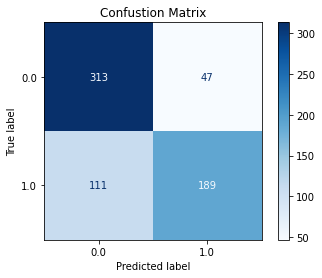

In [15]:
plot_confusion_matrix(knn_model, X_test.reshape(X_test.shape[0],-1), y_test, cmap=plt.cm.Blues)
plt.title('Confustion Matrix')
plt.show()

### ROC Curve

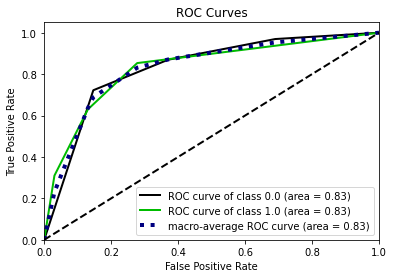

In [16]:
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, knn_model.predict_proba(X_test.reshape(X_test.shape[0],-1)), plot_micro=False)
plt.show()

In [17]:
target_names = ['benign', 'malignant']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      benign       0.74      0.87      0.80       360
   malignant       0.80      0.63      0.71       300

    accuracy                           0.76       660
   macro avg       0.77      0.75      0.75       660
weighted avg       0.77      0.76      0.76       660



### Decision Tree / Random Forest